In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import torch
from lsh import LSH

In [2]:
from torchinterp import Interp1d

In [3]:
df_train = pd.read_csv("../dataset/pointcloud_mnist_2d/train.csv")
df_test = pd.read_csv("../dataset/pointcloud_mnist_2d/test.csv")

X = df_train[df_train.columns[1:]].to_numpy()
y = df_train[df_train.columns[0]].to_numpy()

X = X.reshape(X.shape[0], -1, 3)

X.shape, y.shape

((60000, 351, 3), (60000,))

In [4]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [5]:
# set size of each sample
sizes = torch.sum((X[:, :, 2] > 0).long(), dim=1).unsqueeze(1)

In [6]:
X = X[:, :, 0:2]

In [18]:
from itertools import combinations
from tqdm.notebook import tqdm

In [33]:
X[0:5, :, 0].shape

torch.Size([5, 351])

In [59]:
X_j0 = compute_jp(X[:, :, 0], 1)
X_j1 = compute_jp(X[:, :, 1], 1)
X_j = np.stack((X_j0, X_j1), axis=2).squeeze()
print(X_j.shape)

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

(60000, 351, 2)


In [54]:
def compute_jp(X, janossy_k):
    X_janossy = []
    for index in tqdm(range(len(X))):
        temp = list(X[index])
        temp = [int(x) for x in temp]
        temp.sort()
        temp = list(combinations(temp, janossy_k))
        temp = [list(x) for x in temp]
        X_janossy.append(temp)
    return np.array(X_janossy)

In [60]:
X_j_np = X_j.reshape(X_j.shape[0], -1)

In [63]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

In [64]:
# didn't use LHSForest because according to documentation, it has been deprecated due to poor performance. 
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_j_np , y.numpy())

KNeighborsClassifier(n_neighbors=3)

In [65]:
X_test = df_test[df_test.columns[1:]].to_numpy()
y_test = df_test[df_test.columns[0]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], -1, 3)

In [66]:
X_test = torch.from_numpy(X_test)

test_sizes = torch.sum((X_test[:, :, 2] > 0).long(), dim=1).unsqueeze(1)
X_test = X_test[:, :, :2]

In [67]:
X_test.shape

torch.Size([10000, 351, 2])

In [68]:
X_test_j0 = compute_jp(X_test[:, :, 0], 1)
X_test_j1 = compute_jp(X_test[:, :, 1], 1)
X_test_j = np.stack((X_test_j0, X_test_j1), axis=2).squeeze()
X_test_j_np = X_test_j.reshape(X_test_j.shape[0], -1)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [70]:
preds = neigh.predict(X_test_j_np)

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [71]:
accuracy_score(preds, y_test)

0.7656

In [74]:
accs = []
num_neighs = 20
for i in tqdm(range(1, num_neighs)):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_j_np, y.numpy())
    preds = neigh.predict(X_test_j_np)
    accs.append(accuracy_score(preds, y_test))

  0%|          | 0/19 [00:00<?, ?it/s]

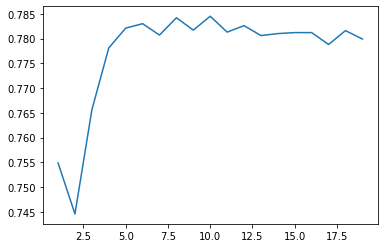

In [75]:
plt.plot(range(1, num_neighs), accs)
plt.show()

In [76]:
accuracy_score(preds, y_test)

0.7799

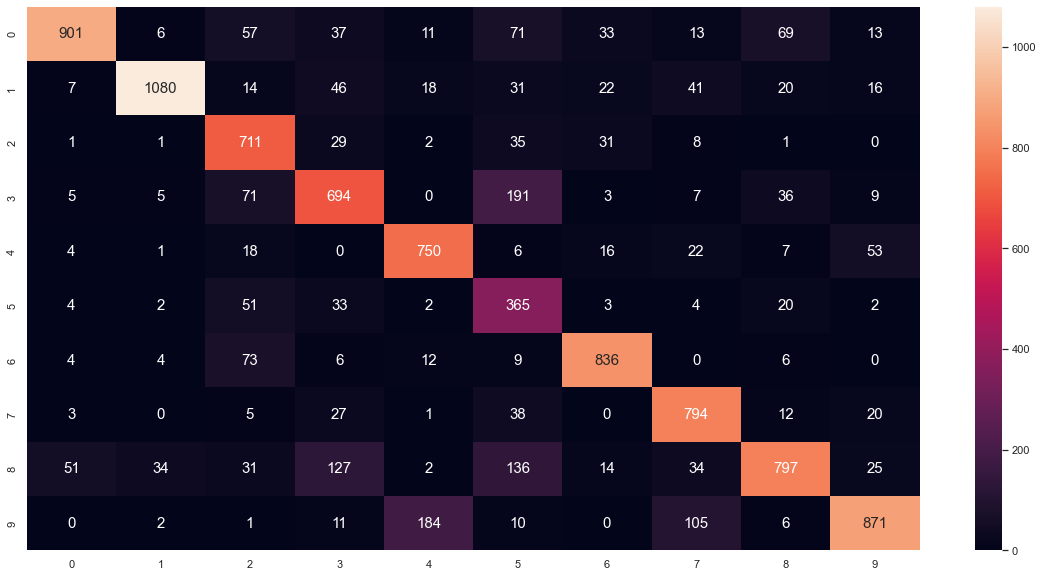

In [77]:
import seaborn as sn
cm = confusion_matrix(preds, y_test)

df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize=(20,10))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='g')

plt.show()